In [1]:
import os
import sys
path=!pwd
sys.path.append(os.path.join(path[0], '..'))
import numpy as np
import math
import pandas as pd
import re
from datetime import date, datetime, timedelta
import json
from abc import ABCMeta, abstractmethod
import boto3
# import snowflake.connector
from io import StringIO
import logging 
from scipy.optimize import curve_fit


logger = logging.getLogger()
logging.basicConfig(level=logging.INFO)
logger.info(f'Starting Notebook')

from utils import *

class Utils():
    @staticmethod
    def to_csv_s3(content, bucket, key_path, filename):
        client = boto3.client('s3')
        key = os.path.join(key_path, filename)
        csv_buffer = StringIO()
        content.to_csv(csv_buffer)
        client.put_object(Bucket=bucket, Key=key, Body=csv_buffer.getvalue())
        logger.info(f'Saved to {bucket}/{key}')
    
    @staticmethod
    def to_pkl_s3(content, bucket, key_path, filename):
        client = boto3.client('s3')
        key = os.path.join(key_path, filename)
        obj = pickle.dumps(content)
        client.put_object(Bucket=bucket, Key=key, Body=obj)
        logger.info(f'Saved model to {os.path.join(bucket, key)}')
        logger.info(f'Saved to {bucket}/{key}')

    @staticmethod
    def read_csv_s3(bucket, key_path,filename):
        client = boto3.client('s3')
        key = os.path.join(key_path, filename)
        obj = client.get_object(Bucket=bucket, Key=key)
        df = pd.read_csv(obj['Body'], na_values="\\N")
        logger.info(f'Read from {bucket}/{key}')
        return df
        
    @staticmethod
    def read_pkl_s3(bucket, key_path,filename):
        client = boto3.client('s3')
        key = os.path.join(key_path, filename)
        obj = client.get_object(Bucket=bucket, Key=key)
        body = obj['Body'].read()
        model = pickle.loads(body)
        logger.info(f'Read from {bucket}/{key}')
        return model    

class Credentials(metaclass=ABCMeta):
    pass
    
    
class SSMPSCredentials(Credentials):
    def __init__(self, secretid: str):
        self._secretid = secretid
        self._secrets = {}
        
    def get_keys(self):
        """
        credential fetching 
        """
        _aws_sm_args = {'service_name': 'secretsmanager', 'region_name': 'us-east-1'}
        secrets_client = boto3.client(**_aws_sm_args)
        get_secret_value_response = secrets_client.get_secret_value(SecretId=self._secretid)
        return get_secret_value_response
    
    
class BaseConnector(metaclass=ABCMeta):
    @abstractmethod
    def connect(self):
        raise NotImplementedError

        
class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )
        return ctx

    
def run_query(querystr, ctx):
    cursor_list = ctx.execute_string(
        querystr
        )
    df = pd.DataFrame.from_records(cursor_list[-1].fetchall(), columns=[x[0] for x in cursor_list[-1].description])
    df.columns= df.columns.str.lower()
    return df

import plotly.express as px
def get_simple_plot(df_plt, x, y, grpby, text, title=''):
    if title=='':
        title = f'{y} vs {x}'
    df_plt[grpby] = df_plt[grpby].astype(str)
    fig = px.line(df_plt,
                  x=x, 
                  y=y, 
                  title=title,
                  color=grpby, 
                  hover_data=[text],
                  width=800, height=400)
    fig.show()
    return 


## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
# conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
# ctx=conn.connect("MAX_PROD","DATASCIENCE_STAGE")
# cur = ctx.cursor()

input_bucket="hbo-ingest-datascience-content-dev"
output_bucket="hbo-outbound-datascience-content-dev"
key_path = 'cost_allocation/dev'

INFO:root:Starting Notebook
INFO:matplotlib.font_manager:Generating new fontManager, this may take some time...


## SVOD Monthly, Retail,  domestic

In [3]:
df_60_0 = Utils.read_csv_s3(input_bucket, key_path, 'churn_user_stream_full_genpop_60d_20221001_as.csv')
df_60_1 = Utils.read_csv_s3(input_bucket, key_path, 'churn_user_stream_full_genpop_60d_20221101_as.csv')
df_60_2 = Utils.read_csv_s3(input_bucket, key_path, 'churn_user_stream_full_genpop_60d_20221201_as.csv')

df_60 = pd.concat([df_60_0, df_60_1, df_60_2])
df_60['tenure_months'] = df_60['sub_month']
df_60['monthly_hours_viewed'] = np.where(df_60['tenure_months']>1, df_60['hours_viewed']/2, df_60['hours_viewed'])
df_60['genre_original'] = df_60.genre
df_60['genre'] = np.where(~df_60.genre.isin(['action','comedy','drama']), 'other', df_60.genre)
df_60 = df_60[df_60.tenure_months>=2]

# df_60['monthly_titles_viewed'] = np.where(df_60['tenure_months']>1, df_60['titles_viewed']/2, df_60['titles_viewed'])
df_60 = df_60.reset_index()
df_60=df_60.fillna(0)

print(df_60.shape)
display(df_60.head())
# display(df_60.groupby(by=['segment_name']).count())

# display(df_hv.loc[1,'hbo_uuid'])
# display(df_hv[df_hv.hbo_uuid=='77ad0a1d78392ed3084d4e2e5fd52d604db4d15e04ada1ea3b25a14c4bcd0ccc'].sort_values(by='request_date'))
# display(df_ha.head())

Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
INFO:root:Read from hbo-ingest-datascience-content-dev/cost_allocation/dev/churn_user_stream_full_genpop_60d_20221001_as.csv
INFO:root:Read from hbo-ingest-datascience-content-dev/cost_allocation/dev/churn_user_stream_full_genpop_60d_20221101_as.csv
INFO:root:Read from hbo-ingest-datascience-content-dev/cost_allocation/dev/churn_user_stream_full_genpop_60d_20221201_as.csv


(43944021, 15)


,index,Unnamed: 0,hbo_uuid,hurley_user_id,is_cancel,sub_month,program_type,content_category,genre,old_new,medal,hours_viewed,tenure_months,monthly_hours_viewed,genre_original
0,0,0,faa607e8c358840d5c32a303faefb51f7b0396129df7dc...,gKs5k+xHZl4Ej+2u5f5z+9UPBz8M14gLuOwC+sZjjUM=,False,18,acquired,series,comedy,library,0,28.190833,18,14.095417,comedy
1,1,1,c04733712d9a99b40fa4c245d18d3989c1c5f93e380cc3...,oDUyAUv81FLrU46qOWLKTt1fy4hCyCZ9WM8JY0jr8Rg=,False,10,acquired,series,drama,library,0,224.280833,10,112.140417,drama
2,2,2,32760ad88d155a9dd32483eb5d4eae72c53dc82f1dfd76...,G6xLZUS3njzF0KsLYcD5Ibjni8mjfw5pKwG00GPpOrM=,False,14,original,series,drama,current,Bronze,7.677500,14,3.838750,drama
3,3,3,4af122a6af5270dcc1c6947f517c91681674f2fb73a72f...,2FaV+lMOK8dZLECBBsdh+5wn1mCBTiere8NjMcCOG+Y=,False,18,original,series,drama,current,Silver,1.152500,18,0.576250,drama
4,4,4,0fdd4d1d4f32cea76c1287fcdf860720fb965ffb7b2c5b...,qL1QHf4yVzCd4v+D61zw3JcR6RJVfOa+dM8nd+WgbN0=,False,27,acquired,movies,comedy,library,0,8.245000,27,4.122500,comedy


In [48]:
s=df_60[(df_60.genre.isin(['comedy','drama','action']) & (df_60.medal!=0))].groupby(by=['old_new','genre','medal']).count()
display(s)

index  Unnamed: 0  hbo_uuid  hurley_user_id  \
old_new genre  medal                                                     
current action Bronze     165937      165937    165937          165937   
               Gold       313469      313469    313469          313469   
               Platinum   239772      239772    239772          239772   
               Silver      55072       55072     55072           55072   
        comedy Bronze     155052      155052    155052          155052   
               Gold       300376      300376    300376          300376   
               Platinum    43519       43519     43519           43519   
               Silver     223916      223916    223916          223916   
        drama  Bronze     162341      162341    162341          162341   
               Gold       776113      776113    776113          776113   
               Platinum  1596240     1596240   1596240         1596240   
               Silver      71396       71396     71396           71396   
library action Bronze      26840       26840     26840           26840   
               Gold       281199      281199    281199          281199   
               Platinum   175708      175708    175708          175708   
               Silver      29419       29419     29419           29419   
        comedy Bronze      17997       17997     17997           17997   
               Gold         6183        6183      6183            6183   
               Platinum    23372       23372     23372           23372   
               Silver      22883       22883     22883           22883   
        drama  Bronze      23807       23807     23807           23807   
               Gold       322109      322109    322109          322109   
               Platinum    12647       12647     12647           12647   
               Silver      66364       66364     66364           66364   

                         is_cancel  sub_month  program_type  content_category  \
old_new genre  medal                                                            
current action Bronze       165937     165937        165937            165937   
               Gold         313469     313469        313469            313469   
               Platinum     239772     239772        239772            239772   
               Silver        55072      55072         55072             55072   
        comedy Bronze       155052     155052        155052            155052   
               Gold         300376     300376        300376            300376   
               Platinum      43519      43519         43519             43519   
               Silver       223916     223916        223916            223916   
        drama  Bronze       162341     162341        162341            162341   
               Gold         776113     776113        776113            776113   
               Platinum    1596240    1596240       1596240           1596240   
               Silver        71396      71396         71396             71396   
library action Bronze        26840      26840         26840             26840   
               Gold         281199     281199        281199            281199   
               Platinum     175708     175708        175708            175708   
               Silver        29419      29419         29419             29419   
        comedy Bronze        17997      17997         17997             17997   
               Gold           6183       6183          6183              6183   
               Platinum      23372      23372         23372             23372   
               Silver        22883      22883         22883             22883   
        drama  Bronze        23807      23807         23807             23807   
               Gold         322109     322109        322109            322109   
               Platinum      12647      12647         12647             12647   
               Silver        66364      66364         66364             66364

## Medal- genre curve, fitting multiple curves 

In [16]:
def get_simple_plot_multiple(df_plt, x, y, x_fit, y_fit, params, title=''):
    if title=='':
        
        title = f'{y} vs {x}'
       
    a_fit, b_fit, c_fit = params
    annotation_x_loc = 50
    annotation_y_loc = y_fit.min() +(y_fit.max()  - y_fit.min() )/2 
        
    fig = px.scatter(df_plt,
                  x=x, 
                  y=y, 
                  title=title,
                  width=600, height=400)
    fig.add_scatter( 
              x=x_fit, 
              y=y_fit)

    fig.update_layout(
        template='simple_white',
        showlegend=False,
        xaxis=dict(range=[0,50]),
        annotations=[
        dict(
            x=annotation_x_loc,  # x-coordinate for the text
            y=annotation_y_loc,  # y-coordinate for the text
            text='y= {:.2f} * e^({:.2f} * hours_viewed) + {:.2f}'.format(a_fit, b_fit, c_fit),  # the text to display
            showarrow=False,  # disable arrow for the annotation
            xanchor='right',
            font=dict(
                family='Arial',  # specify font family
                size=18,  # specify font size
                color='black'  # specify font color
            )
        )
    ]
) 
    fig.show()
    return 

def get_churn_bin(df_in, grpby):
    df = df_in.groupby(by=['hbo_uuid']+ grpby +['is_cancel']).sum().reset_index()
    df = df[df.monthly_hours_viewed<=60]
    nbins = 50
    df['hours_viewed_bin'] = pd.qcut(df['monthly_hours_viewed'], np.linspace(0,1,nbins), duplicates='drop')
    df['hours_viewed_bin'] = df['hours_viewed_bin'].apply(lambda x: (x.left+x.right)/2)
    df['hours_viewed_bin'] = df['hours_viewed_bin'].astype('float')
    df['churn'] = 1*df['is_cancel']  
    
#     df=df[df.ttl_stream_hrs_bin<=300]
    df_bin = df.groupby(grpby+['hours_viewed_bin']).agg({'churn':'mean', 'hbo_uuid':'count','is_cancel':'sum','monthly_hours_viewed':'sum'}).reset_index()
    
    return(df_bin)


def exponential_decay(x, a, b,c):
    return a * np.exp(b * x) + c

def fit_exponential(x_data, y_data, p0, param_bounds):
    x_fit = np.linspace(0, x_data.max(), 100)
    
    params, _ = curve_fit(exponential_decay, np.array(x_data), y_data, p0, bounds=param_bounds)
    return x_fit, params

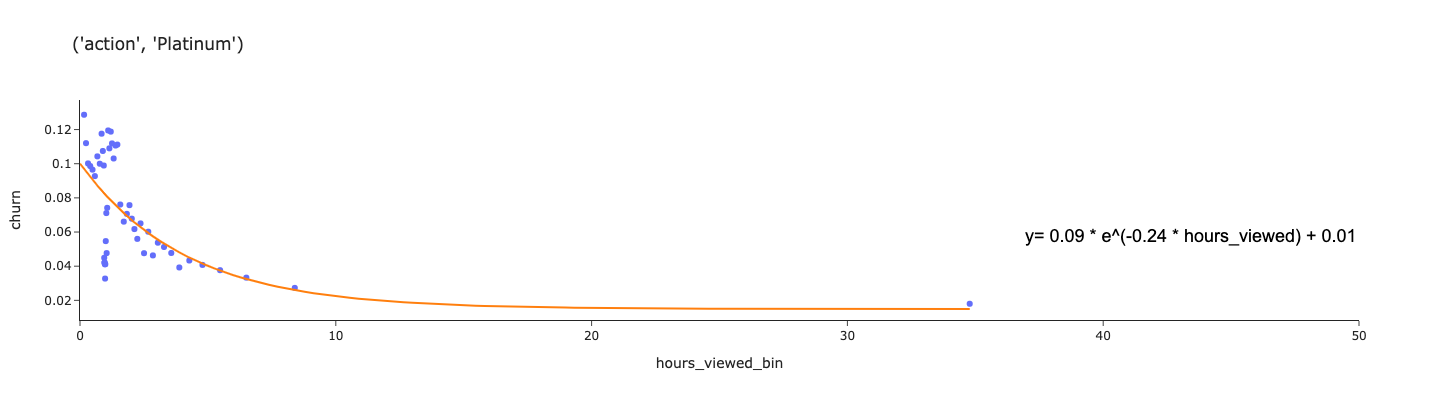

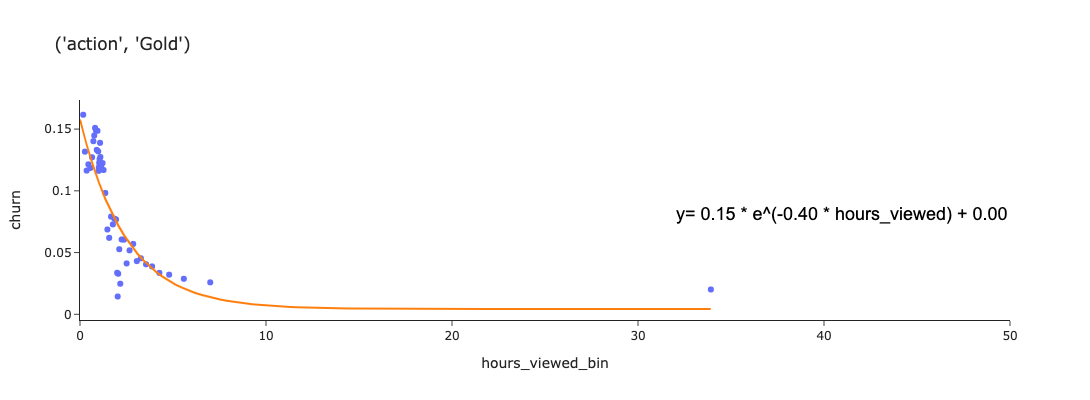

In [ ]:
old_new = ['current','library']
genre = ['action','comedy','drama','other']
medal = ['Platinum','Gold','Silver','Bronze']
# acq = ['']
x_var = 'hours_viewed_bin'

param_dic = {}

for g, m in list(itertools.product(genre, medal)): #old_new,
    df_fit = df_60[(df_60.genre==g) & (df_60.medal==m)] ##  (df_plt.old_new==o) 
    df_fit = get_churn_bin(df_fit, [])
    list_id = df_fit['hbo_uuid'].unique()
    
    df_zero = df_60[~df_60['hbo_uuid'].isin(list_id)]
    df_zero['hours_viewed_bin'] = 0
    df_zero['churn'] = 1*df_zero['is_cancel'] 
    df_zero = df_zero.groupby(by=['hours_viewed_bin']).agg({'churn':'mean', 'hbo_uuid':'count','is_cancel':'sum','monthly_hours_viewed':'sum'}).reset_index()

    df_i = pd.concat([df_zero, df_fit])
    df_i = df_i[df_i.is_cancel>=30]

    x_var = df_i.hours_viewed_bin
    y_data = df_i.churn
    p0 = [0.5, 0.5, 0.1] 
    param_bounds = ([0, -np.inf, 0], [np.inf, 1, np.inf])

    x_fit, params = fit_exponential(x_var, y_data, p0, param_bounds)
    a_fit, b_fit, c_fit = params
    
    y_fit = exponential_decay(x_fit, a_fit, b_fit, c_fit)
    get_simple_plot_multiple(df_fit, 'hours_viewed_bin', 'churn', x_fit, y_fit, params, f'{g, m}')
    param_dic[f'{g}_{m}'] = params
    
    del df_zero, df_fit, df_i

In [ ]:
param_dic

## Hours_view distribution


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


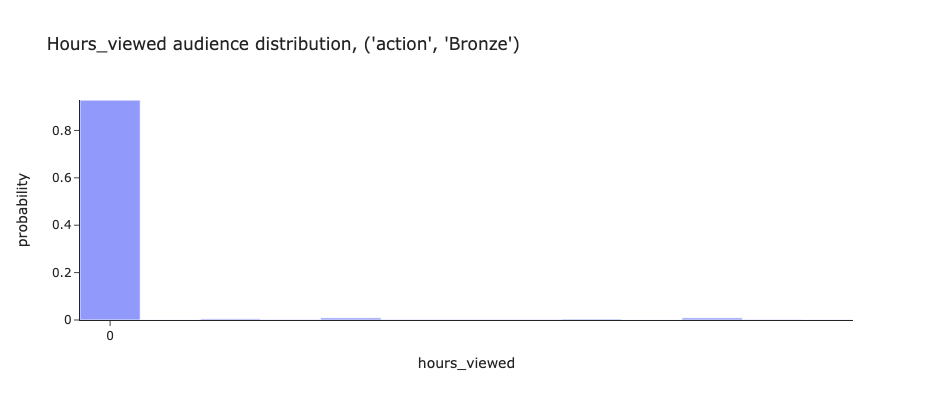


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


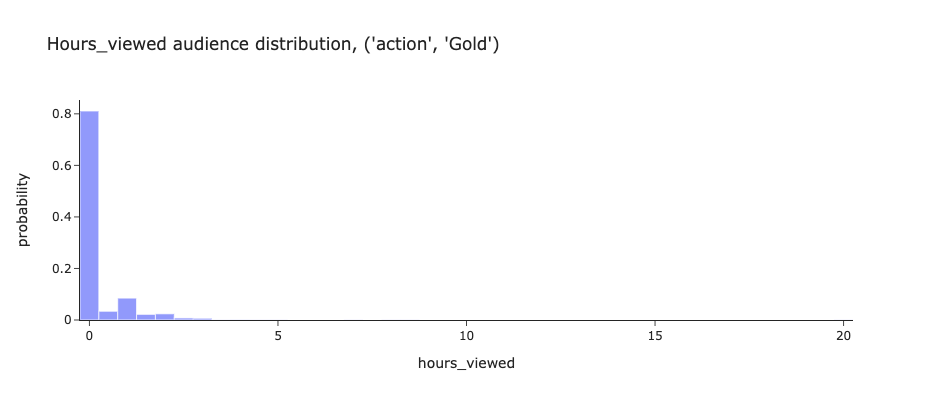


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


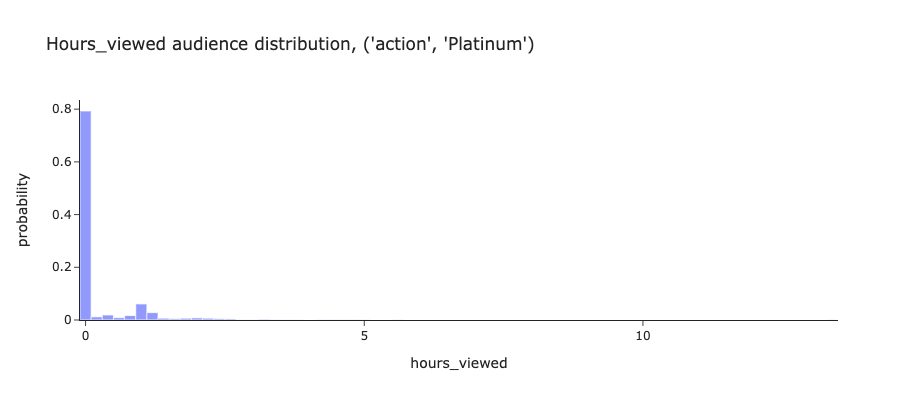


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


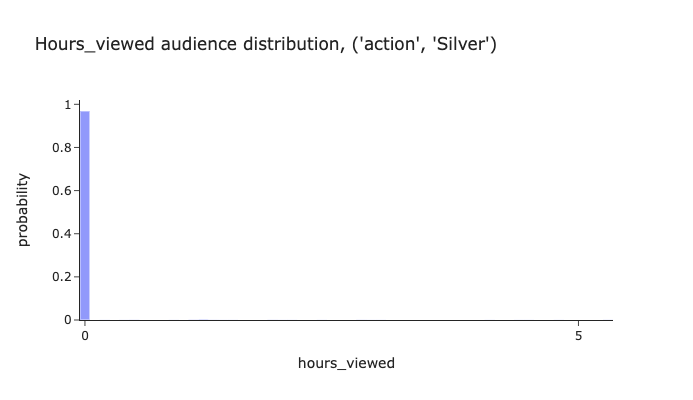


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


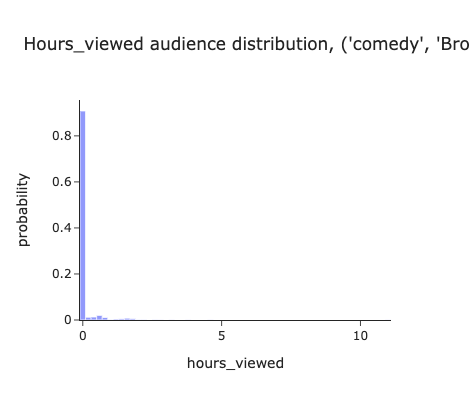


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


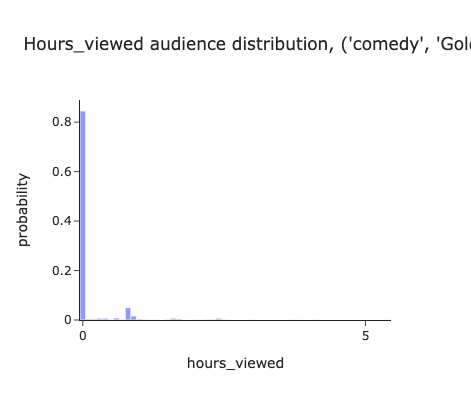


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


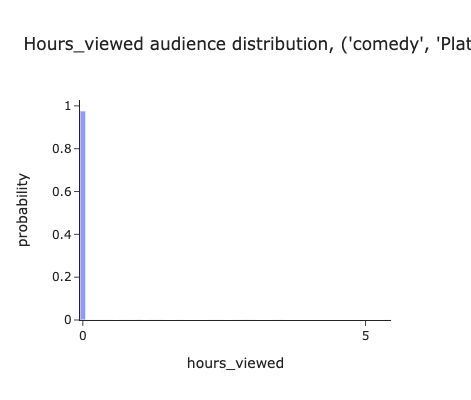


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


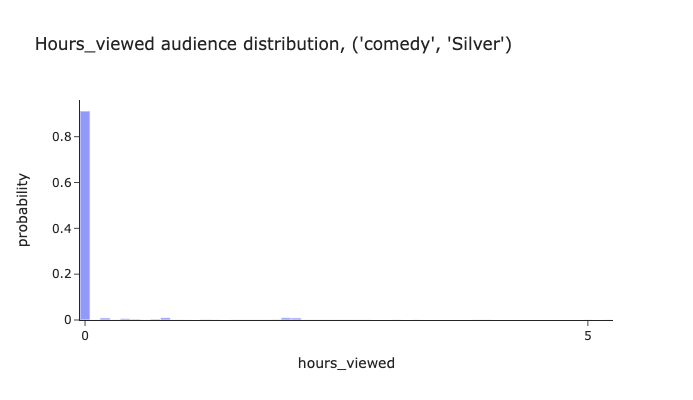


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


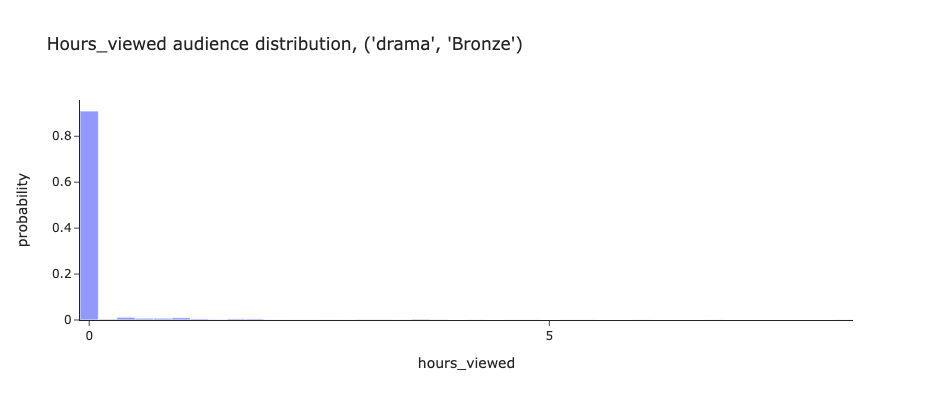


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


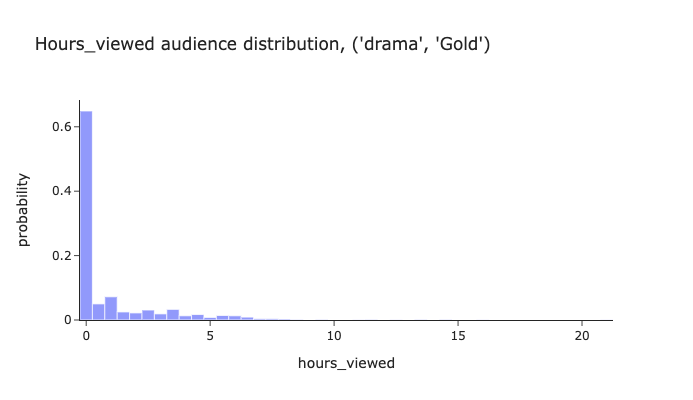


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


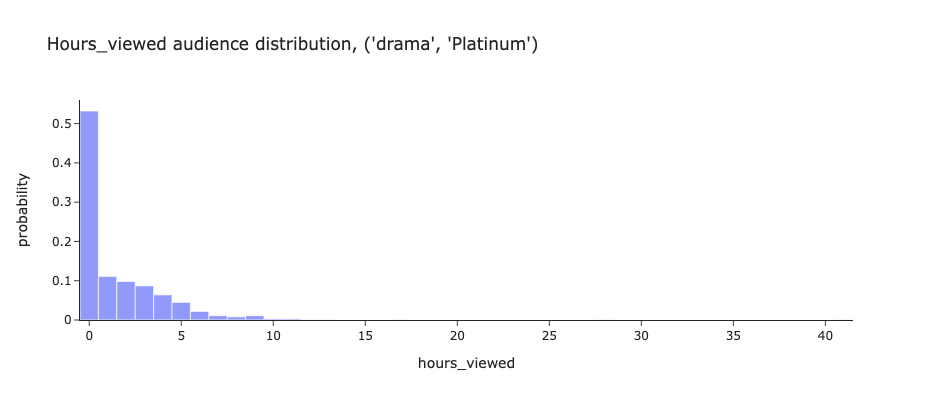


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


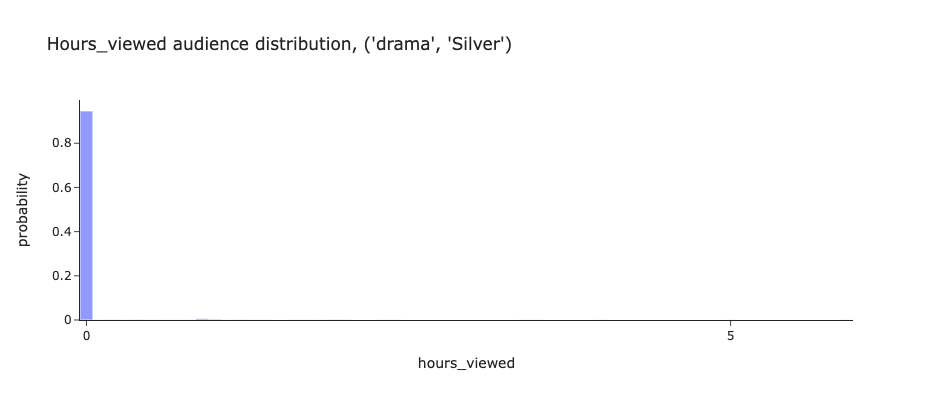


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


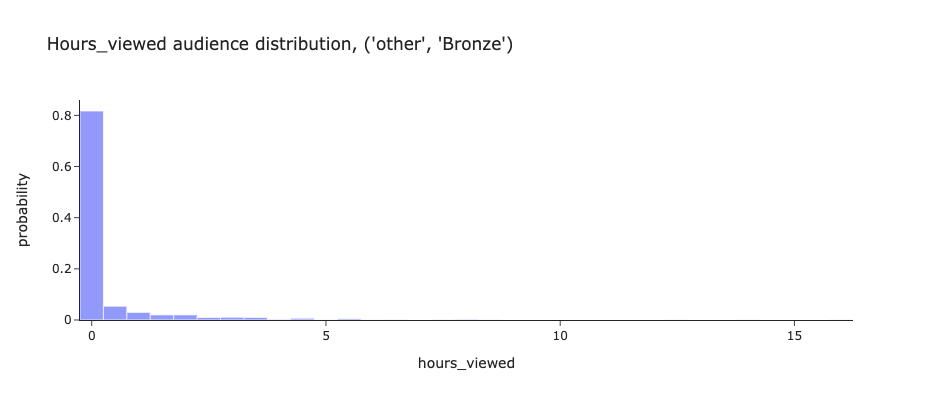


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


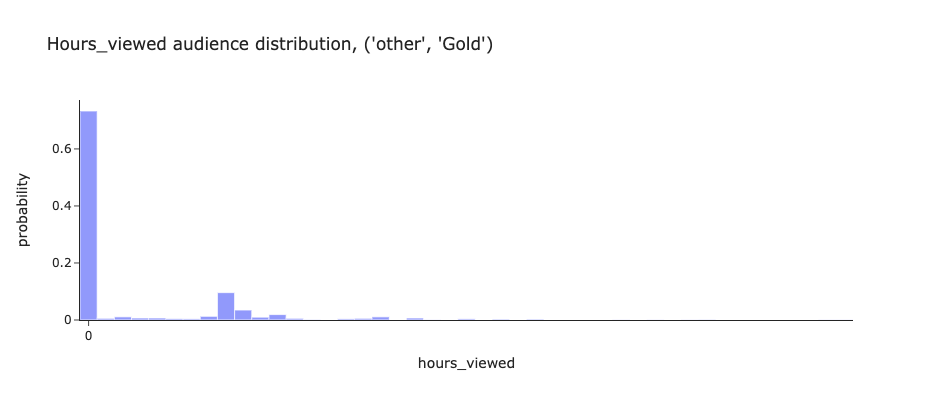


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


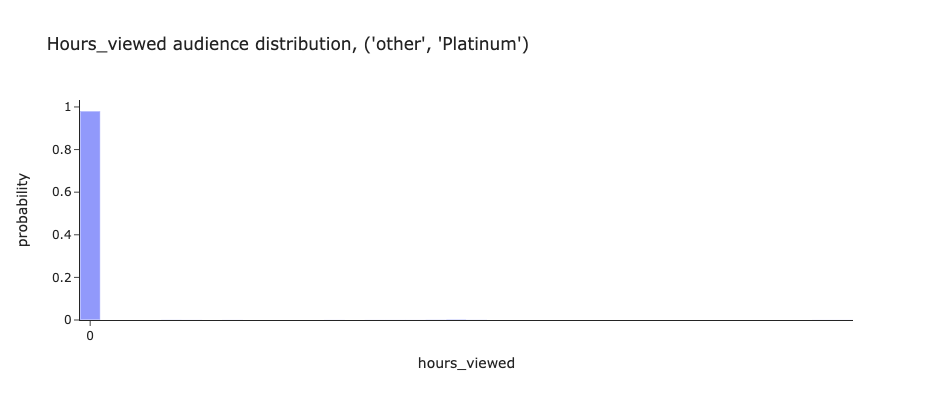


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


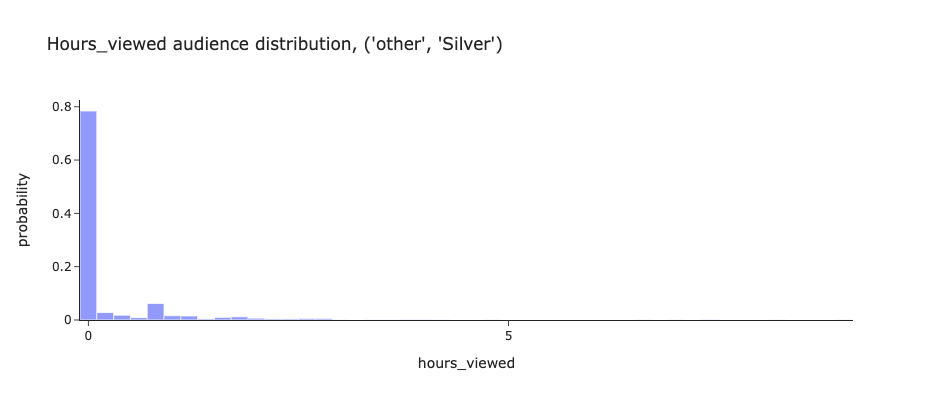

In [36]:
def get_histogram(df_plt, x, title='', histnorm='probability'):
    if title=='':
        title = f'{x}'
    fig = px.histogram(df_plt, x=x,
                  title=title, 
                  width=600, height=400, opacity=0.7, histnorm='probability', nbins=80)
    fig.update_layout(showlegend=False, 
                      xaxis_title_text = 'hours_viewed',
                      barmode='overlay', 
                      xaxis=dict(dtick=5),
                      template='simple_white',)
    fig.show()
    return 


for g, m in list(itertools.product(genre, medal)): #old_new,
    df_fit = df_60[(df_60.genre==g) & (df_60.medal==m)] ##  (df_plt.old_new==o) 
    df_fit = df_fit[(df_fit.monthly_hours_viewed<=80)].groupby(['hbo_uuid','sub_month']).sum().reset_index()
    
    list_id = df_fit['hbo_uuid'].unique()
    df_zero = df_60[~df_60['hbo_uuid'].isin(list_id)]
    df_zero['monthly_hours_viewed'] = 0
    df_zero = df_zero.groupby(['hbo_uuid','sub_month']).sum().reset_index()

    df_i= pd.concat([df_zero, df_fit])
    get_histogram(df_i[df_i.monthly_hours_viewed<=80].sample(n=1000), 'monthly_hours_viewed', f'Hours_viewed audience distribution, {g,m}')


## Get weighted average retention value

In [11]:
genre_list=[]
medal_list=[]
churn_per_hr_viewed_person_list = []

for g, m in list(itertools.product(['other'], ['Gold'])): #old_new,
    ## Get hours_viewed raw data 
#     print(g,m)
    df_fit = df_60[(df_60.genre==g) & (df_60.medal==m)] ##  (df_plt.old_new==o) 
    df_fit = df_fit[(df_fit.monthly_hours_viewed<=80)].groupby(['hbo_uuid','sub_month']).sum().reset_index()

    list_id = df_fit['hbo_uuid'].unique()
    df_zero = df_60[~df_60['hbo_uuid'].isin(list_id)]
    df_zero['monthly_hours_viewed'] = 0
    df_zero = df_zero.groupby(['hbo_uuid','sub_month']).sum().reset_index()
    df_i= pd.concat([df_zero, df_fit])

    ## Bin and get distribution
    bins = pd.cut(df_i['monthly_hours_viewed'], np.linspace(0,80,81))
    df_p = bins.value_counts(normalize=True).reset_index()
    df_p.columns = ['hours_viewed', 'probability']
    df_p['hours_viewed'] = df_p['hours_viewed'].apply(lambda x: (x.left+x.right)/2)
    df_p.hours_viewed = df_p.hours_viewed.astype(float)
    df_p = df_p.sort_values(by='hours_viewed', ascending=True)

    # Apply curve params
    a, b, c = param_dic[f'{g}_{m}']
    df_p['slope'] = -a*b * np.exp(-b*df_p.hours_viewed)
    df_p['weighted_slope'] = df_p['slope'] * df_p['probability']

    churn_metric = df_p['weighted_slope'].sum()
    genre_list.append(g)
    medal_list.append(m)
    churn_per_hr_viewed_person_list.append(churn_metric)
    
#     del df_zero, df_fit


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
print(a,b,c)

0.0933727474541026 0.2783158436229516 0.014043023992332752


In [12]:
df_p

,hours_viewed,probability,slope,weighted_slope
0,0.5,7.071601e-01,-9.107718e-02,-6.440615e-02
1,1.5,2.229346e-01,-4.861190e-02,-1.083728e-02
2,2.5,4.554898e-02,-2.594631e-02,-1.181828e-03
3,3.5,1.314496e-02,-1.384869e-02,-1.820404e-04
4,4.5,4.995729e-03,-7.391653e-03,-3.692669e-05
5,5.5,2.278423e-03,-3.945250e-03,-8.988950e-06
6,6.5,1.148621e-03,-2.105754e-03,-2.418713e-06
7,7.5,6.996574e-04,-1.123933e-03,-7.863683e-07
8,8.5,4.583731e-04,-5.998926e-04,-2.749746e-07
9,9.5,3.286575e-04,-3.201891e-04,-1.052325e-07


In [7]:
## Calculating weighted mean of hours_viewed

## Define final dataframe 
genre_list=[]
medal_list=[]
churn_per_hr_viewed_person_list = []

for g, m in list(itertools.product(genre, medal)): #old_new,
    ## Get hours_viewed raw data 
#     print(g,m)
    df_fit = df_60[(df_60.genre==g) & (df_60.medal==m)] ##  (df_plt.old_new==o) 
    df_fit = df_fit[(df_fit.monthly_hours_viewed<=80)].groupby(['hbo_uuid','sub_month']).sum().reset_index()

    list_id = df_fit['hbo_uuid'].unique()
    df_zero = df_60[~df_60['hbo_uuid'].isin(list_id)]
    df_zero['monthly_hours_viewed'] = 0
    df_zero = df_zero.groupby(['hbo_uuid','sub_month']).sum().reset_index()
    df_i= pd.concat([df_zero, df_fit])

    ## Bin and get distribution
    bins = pd.cut(df_i['monthly_hours_viewed'], np.linspace(0,80,81))
    df_p = bins.value_counts(normalize=True).reset_index()
    df_p.columns = ['hours_viewed', 'probability']
    df_p['hours_viewed'] = df_p['hours_viewed'].apply(lambda x: (x.left+x.right)/2)
    df_p.hours_viewed = df_p.hours_viewed.astype(float)
    df_p = df_p.sort_values(by='hours_viewed', ascending=True)

    # Apply curve params
    a, b, c = param_dic[f'{g}_{m}']
    df_p['slope'] = a*b * np.exp(b*df_p.hours_viewed)
    df_p['weighted_slope'] = df_p['slope'] * df_p['probability']

    churn_metric = df_p['weighted_slope'].sum()
    genre_list.append(g)
    medal_list.append(m)
    churn_per_hr_viewed_person_list.append(churn_metric)
    
    del df_zero, df_fit

    
df_retention = pd.DataFrame({'genre': genre_list, 
                   'medal': medal_list, 
                   'churn_per_hr_person':churn_per_hr_viewed_person_list})

df_retention





A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,genre,medal,churn_per_hr_person
0,action,Platinum,4.031166e+01
1,action,Gold,1.095467e+07
2,action,Silver,2.276516e-02
3,action,Bronze,3.323024e+02
4,comedy,Platinum,3.595920e-02
5,comedy,Gold,6.351901e+05
6,comedy,Silver,1.046065e+02
7,comedy,Bronze,1.228022e+08
8,drama,Platinum,8.537563e-02
9,drama,Gold,4.616194e-01


In [ ]:
input_bucket="hbo-ingest-datascience-content-dev"
key_path = 'cost_allocation/dev'

to_csv_s3(df_retention, input_bucket, key_path, 'churn_metric_0811.csv')

## Medal- genre curve, fitting to one- didn't work

In [50]:
## Build curve for medal & genre, put weight 
def resample_data(df_sample, grpby):  
    ## Loop through old and recent data
    df_resample_list = []
    max_count = df_sample.groupby(by=grpby)['hbo_uuid'].max().reset_index()
    min_value= max_count.hbo_uuid.min()
    max_count['weight'] = max_count['hbo_uuid']/min_value
    max_count['weight'] = max_count['weight'].astype(int)
    
    df_sample = df_sample.merge(max_count[grpby+['weight']], on=grpby, how='left')
    print(df_sample.shape)
    df_sample = df_sample.loc[df_sample.index.repeat(df_sample['weight'])]
    print(df_sample.shape)
    return df_sample
 
def get_simple_plot_multiple(df_plt, x, y, x_fit, y_fit, params, title=''):
#     if title=='':
        
#         title = f'{y} vs {x}'
       
# #     a_fit, b_fit, c_fit = params
#     annotation_x_loc = x_fit.max()
#     annotation_y_loc = y_fit.min() +(y_fit.max()  - y_fit.min() )/2 
        
    fig = px.scatter(df_plt,
                  x=x, 
                  y=y, 
                  title=title,
                  width=600, height=400)
    fig.add_scatter( 
              x=x_fit, 
              y=y_fit)

#     fig.update_layout(
#         template='simple_white',
#         showlegend=True,
#         xaxis=dict(range=[0,80]),
#         annotations=[
#         dict(
# #             x=annotation_x_loc,  # x-coordinate for the text
# #             y=annotation_y_loc,  # y-coordinate for the text
# #             text='y= {:.2f} * e^(-{:.2f} * hours_viewed) + {:.2f}'.format(a_fit, b_fit, c_fit),  # the text to display
# #             showarrow=False,  # disable arrow for the annotation
#             xanchor='right',
#             font=dict(
#                 family='Arial',  # specify font family
#                 size=18,  # specify font size
#                 color='black'  # specify font color
#             )
#         )
#     ]
# ) 
#     fig.show()
    return 


In [51]:
def get_dummies(df_in, features):
    for f in features:
        df_f = pd.get_dummies(df_in[f])
        df_in = pd.concat([df_in, df_f], axis=1)
    df_in.columns = df_in.columns.str.lower()
    
    return df_in

def exponential_multi(x, a, b1, b2, b3, b4, b5, b6, c):
    x1, x2, x3, x4, x5, x6 = x
    return a * np.exp(-(b1 * x1 +  b2 * x2 + b3 * x3 + b4*x4 + b5*x5 + b6*x6 )) + c


def fit_exponential_multi(x_var, y_data):
    params, _ = curve_fit(exponential_multi, x_var, y_data)
    print(params)
    
    return x_var,params

In [29]:
df_plt = df_60.copy()
df_plt['genre'] = np.where(~df_plt.genre.isin(['action','comedy','drama']), 'other', df_plt.genre)


# slice by content metadata 
grpby = ['medal','genre']

mask = (df_plt.program_type!=0) & (df_plt.tenure_months>=2)
df_fit = df_plt[mask]
df_i = get_churn_bin(df_fit, grpby)
df_i = resample_data(df_i, grpby)
df_i = get_dummies(df_i, grpby)
df_i = df_i[df_i.is_cancel>=30]

display(df_i.head())
display(df_i.describe(percentiles=[0.1,0.25,0.5,0.75,0.9]))


(380, 8)
(3648, 8)


,medal,genre,hours_viewed_bin,churn,hbo_uuid,is_cancel,monthly_hours_viewed,weight,NaN,bronze,gold,platinum,silver,action,comedy,drama,other
0,0,action,0.1905,0.059401,56952,3383,10410.853611,17,1,0,0,0,0,1,0,0,0
0,0,action,0.1905,0.059401,56952,3383,10410.853611,17,1,0,0,0,0,1,0,0,0
0,0,action,0.1905,0.059401,56952,3383,10410.853611,17,1,0,0,0,0,1,0,0,0
0,0,action,0.1905,0.059401,56952,3383,10410.853611,17,1,0,0,0,0,1,0,0,0
0,0,action,0.1905,0.059401,56952,3383,10410.853611,17,1,0,0,0,0,1,0,0,0


,hours_viewed_bin,churn,hbo_uuid,is_cancel,monthly_hours_viewed,weight,NaN,bronze,gold,platinum,silver,action,comedy,drama,other
count,3648.000000,3648.000000,3648.000000,3648.000000,3.648000e+03,3648.000000,3648.000000,3648.000000,3648.000000,3648.000000,3648.000000,3648.000000,3648.000000,3648.000000,3648.000000
mean,5.343263,0.050883,50745.428728,2580.787281,2.534614e+05,16.864583,0.427083,0.072917,0.276042,0.156250,0.067708,0.213542,0.208333,0.328125,0.250000
std,12.503140,0.009092,43271.521546,2204.742633,9.368881e+05,8.070622,0.494722,0.260035,0.447099,0.363142,0.251279,0.409863,0.406172,0.469595,0.433072
min,0.190500,0.000000,9.000000,0.000000,2.263438e+02,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10%,0.341500,0.036471,4989.100000,257.000000,8.985414e+03,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.792500,0.047714,19500.000000,829.000000,1.800748e+04,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.564500,0.051788,51285.000000,2349.000000,4.225335e+04,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.799000,0.056328,68029.000000,3370.000000,1.329573e+05,25.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.250000
90%,11.087000,0.060515,93844.000000,4821.000000,4.116986e+05,28.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,57.235500,0.101010,238419.000000,11615.000000,7.603804e+06,28.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,medal,genre,hours_viewed_bin,churn,hbo_uuid,is_cancel,monthly_hours_viewed,weight,NaN,bronze,gold,platinum,silver,action,comedy,drama,other
0,0,action,0.1905,0.059401,56952,3383,10410.853611,17,1,0,0,0,0,1,0,0,0
0,0,action,0.1905,0.059401,56952,3383,10410.853611,17,1,0,0,0,0,1,0,0,0
0,0,action,0.1905,0.059401,56952,3383,10410.853611,17,1,0,0,0,0,1,0,0,0
0,0,action,0.1905,0.059401,56952,3383,10410.853611,17,1,0,0,0,0,1,0,0,0
0,0,action,0.1905,0.059401,56952,3383,10410.853611,17,1,0,0,0,0,1,0,0,0


In [ ]:

features= ['hours_viewed_bin','platinum','gold','action','comedy','drama']
x_var = [df_i[f] for f in features]
y_data = df_i.churn
p0 = [0.1, 0.5, 0.1]#,0.1]

x1_fit, params = fit_exponential_multi(x_var, y_data)
a, b1, b2, b3, b4, b5, b6, c = params

(19, 17)


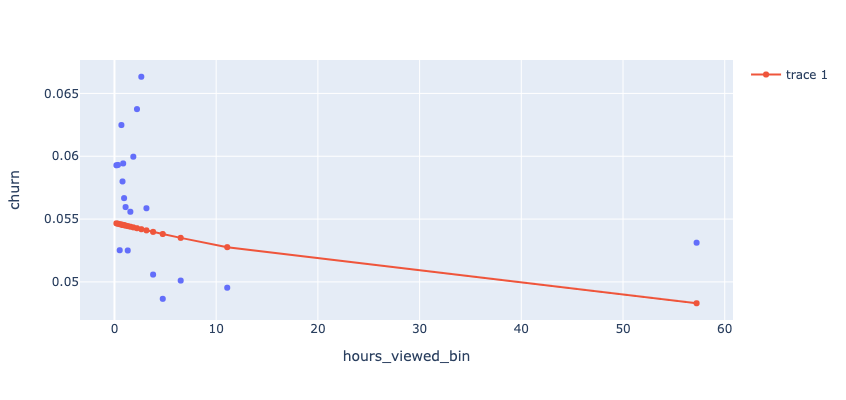

In [47]:
 
def get_simple_plot_multiple(df_plt, x, y, x_fit, y_fit, params, title=''):
#     if title=='':
        
#         title = f'{y} vs {x}'
       
# #     a_fit, b_fit, c_fit = params
#     annotation_x_loc = x_fit.max()
#     annotation_y_loc = y_fit.min() +(y_fit.max()  - y_fit.min() )/2 
        
    fig = px.scatter(df_plt,
                  x=x, 
                  y=y, 
                  title=title,
                  width=600, height=400)
    fig.add_scatter( 
              x=x_fit, 
              y=y_fit)

#     fig.update_layout(
#         template='simple_white',
#         showlegend=True,
#         xaxis=dict(range=[0,80]),
#         annotations=[
#         dict(
# #             x=annotation_x_loc,  # x-coordinate for the text
# #             y=annotation_y_loc,  # y-coordinate for the text
# #             text='y= {:.2f} * e^(-{:.2f} * hours_viewed) + {:.2f}'.format(a_fit, b_fit, c_fit),  # the text to display
# #             showarrow=False,  # disable arrow for the annotation
#             xanchor='right',
#             font=dict(
#                 family='Arial',  # specify font family
#                 size=18,  # specify font size
#                 color='black'  # specify font color
#             )
#         )
#     ]
# ) 
    fig.show()
    return 

# df_j = get_churn_bin(df_fit, [])
# df_j = get_features(df_j, grpby)
# x_fit = [df_j[f] for f in features]


mask = (df_i.platinum==1) & (df_i.genre=='drama')
df_j = df_i[mask].drop_duplicates()
print(df_j.shape)
x_fit = [df_j[f] for f in features]

y_fit = exponential_multi(x_fit, a, b1, b2, b3, b4, b5, b6, c)


get_simple_plot_multiple(df_j, 'hours_viewed_bin', 'churn', x_fit[0], y_fit, params, '')


# # def get_rsquared(df_in, ):
# # residuals = df_j.churn.tolist() - y_fit
# # ss_res = np.sum(residuals**2)
# # ss_tot = np.sum((y_data - np.mean(y_data))**2)
# # r_squared = 1 - (ss_res / ss_tot)
# # print('r_squared:',r_squared)
    
    
# df_j = get_churn_bin(df_plt, [])



# def y_function(x):
#      return -0.01 * np.exp(-0.26 * x)

# df_d = pd.DataFrame({'hours_viewed_bin': np.arange(0, 81)})
# df_d['churn_slope'] = -0.01 * np.exp(-0.26 * df_d['hours_viewed_bin'])

# get_simple_plot_multiple(df_d, 'hours_viewed_bin', 'churn_slope', df_d['hours_viewed_bin'], df_d['churn_slope'], [-0.01, -0.26, 0], '')